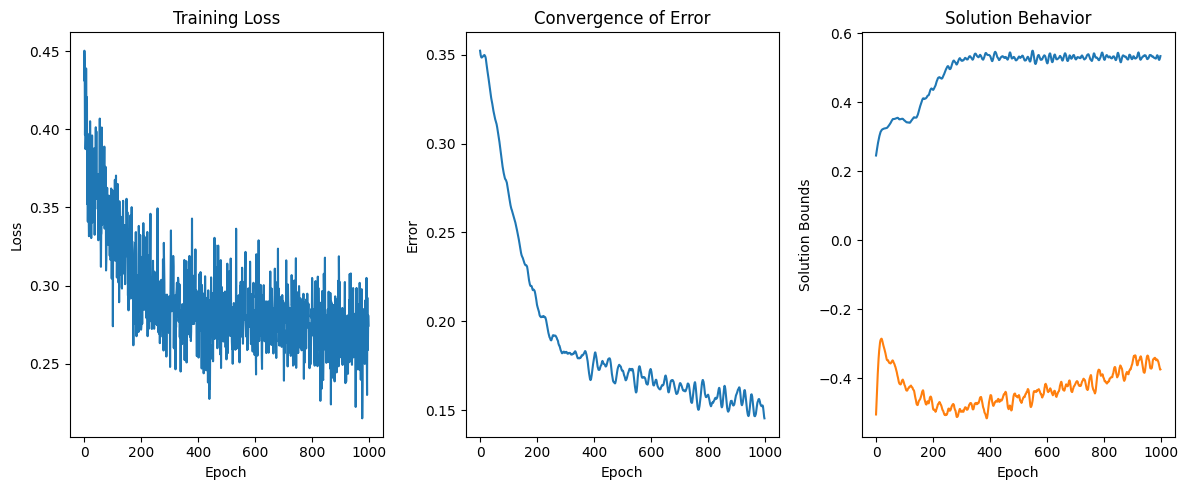

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the PDE function
def pde(x, u, ux, uxx):
    return uxx + u  # Example PDE: u'' + u = 0

# Define the loss function
def loss_function(x, u, ux, uxx):
    pde_residual = pde(x, u, ux, uxx)
    boundary_residual = u - torch.sin(x)
    return torch.mean(pde_residual**2) + torch.mean(boundary_residual**2)

# Compute error against analytical solution
def compute_error(model, x, analytical_sol):
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    u_pred = model(x_tensor).detach().numpy().squeeze()
    u_true = analytical_sol(x)
    error = np.mean((u_pred - u_true)**2)
    return error

# Evaluate the residuals of the PDE
def evaluate_residuals(model, x):
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True).unsqueeze(1)
    u_pred = model(x_tensor)
    ux_pred = torch.autograd.grad(u_pred, x_tensor, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0] #być może ux_pred
    uxx_pred = torch.autograd.grad(ux_pred, x_tensor, grad_outputs=torch.ones_like(ux_pred), create_graph=True)[0] #być może uxx_pred, trzeba sie jeszcze wgłębić
    pde_residual = pde(x_tensor, u_pred, ux_pred, uxx_pred)
    return pde_residual.detach().numpy()

# Define the analytical solution for comparison
def analytical_solution(x):
    return np.sin(x)

# Initialize the neural network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the sample points and initialize lists for tracking errors and losses
x_values = np.linspace(0, 2*np.pi, 100)
errors = []
losses = []
max_vals = []
min_vals = []

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()

    x_sample = np.random.rand(100, 1) * 2 * np.pi
    x_tensor = torch.tensor(x_sample, dtype=torch.float32, requires_grad=True)

    u_pred = model(x_tensor)
    ux_pred = torch.autograd.grad(u_pred, x_tensor, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    uxx_pred = torch.autograd.grad(ux_pred, x_tensor, grad_outputs=torch.ones_like(ux_pred), create_graph=True)[0]

    loss = loss_function(x_tensor, u_pred, ux_pred, uxx_pred)
    loss.backward()
    optimizer.step()

    # Monitor solution behavior
    with torch.no_grad():
        u_values = model(torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)).numpy()
        max_vals.append(np.max(u_values))
        min_vals.append(np.min(u_values))

    # Compute and record error against analytical solution
    error = compute_error(model, x_values, analytical_solution)
    errors.append(error)
    losses.append(loss.item())

# Plot Convergence of Error and Solution Bounds
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 3, 2)
plt.plot(errors, label='Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Convergence of Error')

plt.subplot(1, 3, 3)
plt.plot(max_vals, label='Max Value')
plt.plot(min_vals, label='Min Value')
plt.xlabel('Epoch')
plt.ylabel('Solution Bounds')
plt.title('Solution Behavior')

plt.tight_layout()
plt.show()


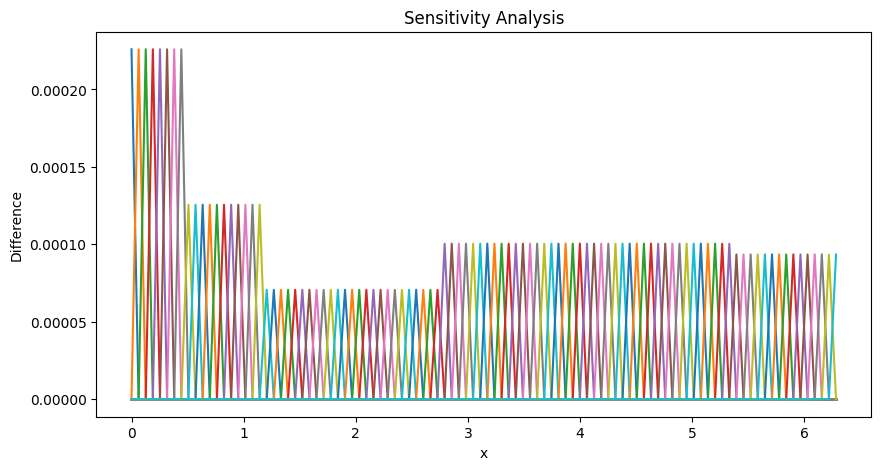

In [ ]:
def sensitivity_analysis(model, x_values, perturbation=0.01):
    original_solution = model(torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)).detach().numpy()
    perturbed_solutions = []

    for i in range(len(x_values)):
        x_perturbed = x_values.copy()
        x_perturbed[i] += perturbation
        perturbed_solution = model(torch.tensor(x_perturbed, dtype=torch.float32).unsqueeze(1)).detach().numpy()
        perturbed_solutions.append(perturbed_solution)

    differences = [np.abs(original_solution - perturbed) for perturbed in perturbed_solutions]
    return differences

perturbations = sensitivity_analysis(model, x_values)
plt.figure(figsize=(10, 5))
for i, diff in enumerate(perturbations):
    plt.plot(x_values, diff, label=f'Perturbation {i+1}')
plt.xlabel('x')
plt.ylabel('Difference')
plt.title('Sensitivity Analysis')
#plt.legend()
plt.show()
